# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Credits
List of websites / repositories that helped reach this solution:

Initial help
* https://medium.com/udacity/the-traffic-sign-classifier-project-1c85a2eb9db5
* https://markbroerkens.github.io/CarND-Traffic-Sign-Classifier-Project/
* https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project

TensorFlow 2 tutorials (abandonned idea of migrating for now)
* https://www.tensorflow.org/tutorials/quickstart/advanced
* http://datahacker.rs/lenet-5-implementation-tensorflow-2-0/
* https://www.tensorflow.org/api_docs/python/tf/keras/losses

Help for augmentation
* https://github.com/jeremy-shannon/CarND-Traffic-Sign-Classifier-Project
* https://github.com/sharathsrini/Traffic-Sign-Classifier

Great presentation suggestions
* https://github.com/shazraz/Traffic-Sign-Classifier/blob/master/Traffic_Sign_Classifier.ipynb

In [1]:
# Environment
# Python 3.7, TensorFlow 1.15
# Includes for this notbook
import pickle # To load training/validation/test data
import matplotlib.pyplot as plt # For all plots
import csv # For sign names
import cv2 # For image augmentation operations
import random # For random sign display
import math # For generic math operations
#import pandas as pd
import numpy as np
from os import listdir # For getting all images in new images folder
from os.path import isfile, join # Checking if file is file or directory / building file path
import matplotlib.image as mpimg # Loading image
#from PIL import Image # Resizing image

import tensorflow as tf # For learning

# from tensorflow.contrib.layers import flatten # Replacedd by tf.keras.layers.Flatten()

---
## Step 0: Load The Data

In [2]:
training_file = "./data/train.p"
validation_file= "./data/valid.p"
testing_file = "./data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [4]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

#### Retrieve labels sign names

In [5]:
# Array to map label ids to sign names
labels_sign_name = {}

with open('signnames.csv') as csvfile:
    reader = csv.reader(csvfile)
    headers = next(reader) 
    for row in reader:
        # Visualized with images
        #print("{:>2} = {}".format(row[0], row[1]))
        labels_sign_name[int(row[0])] = row[1]

#### Visualize random images and labels

In [6]:
# Plots images and labels passed in parameter
def plot_imgs(imgs,lbls=None, header=None, gray=False, imgs_limit=100):
    # Prevent long processing time if not explicitely asked by setting display limit
    if(imgs_limit > len(imgs)):
        imgs_limit = len(imgs)
    
    # Determine size of subplots matrix
    figsize=(20,3.5)
    cols=6
    rows = math.ceil(imgs_limit/cols)
    #gridspec_kw={'width_ratios': [3, 1]}
    fig, axs = plt.subplots(rows, cols, figsize=(figsize[0], figsize[1]*rows))
    fig.subplots_adjust(hspace = .1, wspace=.1)
    # Transform matrix of subplots to a flattened one-dimensional array
    axs = axs.ravel()
    
    # Display each image in subplots
    for i in range(imgs_limit):
        try:            
            axs[i].axis('off')
            if(gray):
                axs[i].imshow(imgs[i], cmap='gray')
            else:
                axs[i].imshow(imgs[i])
            title = ""
            if header is not None:
                title = header[i]
            if lbls is not None: 
                title = title + "{:>2}:{:.25}".format(lbls[i], labels_sign_name[lbls[i]])
            axs[i].set_title("{:.30}".format(title), fontsize=12)
        except:
            print("Image:{} | Label:{} | Label name:{} | Shape:{}".format(i, lbls[i], labels_sign_name[lbls[i]], imgs[i].shape))
            raise
    # Hide unused subplots
    while i < len(axs):
        axs[i].axis('off')
        i = i + 1
    plt.show()

def rand_lbl_index(labels, label):
    indices, = np.nonzero(labels==label)
    index = np.random.choice(indices)
    return index
    
def rand_lbl_img(imgs, labels, label):
    index = rand_lbl_index(labels, label)    
    return imgs[index]
    
# Plot 1 image per labels
def plot_lbl_imgs(imgs, lbls, gray=False):
    # Transform labels into a list, once, to use index function
    lbls_list = lbls.tolist()
    imgs_each = []
    lbls_each = []
    
    # For each unique label in available images
    for lbl in np.unique(lbls):        
        try:        
            # Append label value
            lbls_each.append(lbl)
            # Find index of random occurence of label in the list and append
            imgs_each.append(rand_lbl_img(imgs, lbls, lbl))     
        except ValueError:
            if(labels_sign_name is None):
                print("Could not find image for label {:>2}".format(key))
            else:
                print("Could not find image for label {:>2}:{}".format(key, labels_sign_name[key]))
            pass

    plot_imgs(imgs_each,lbls_each, gray=gray)

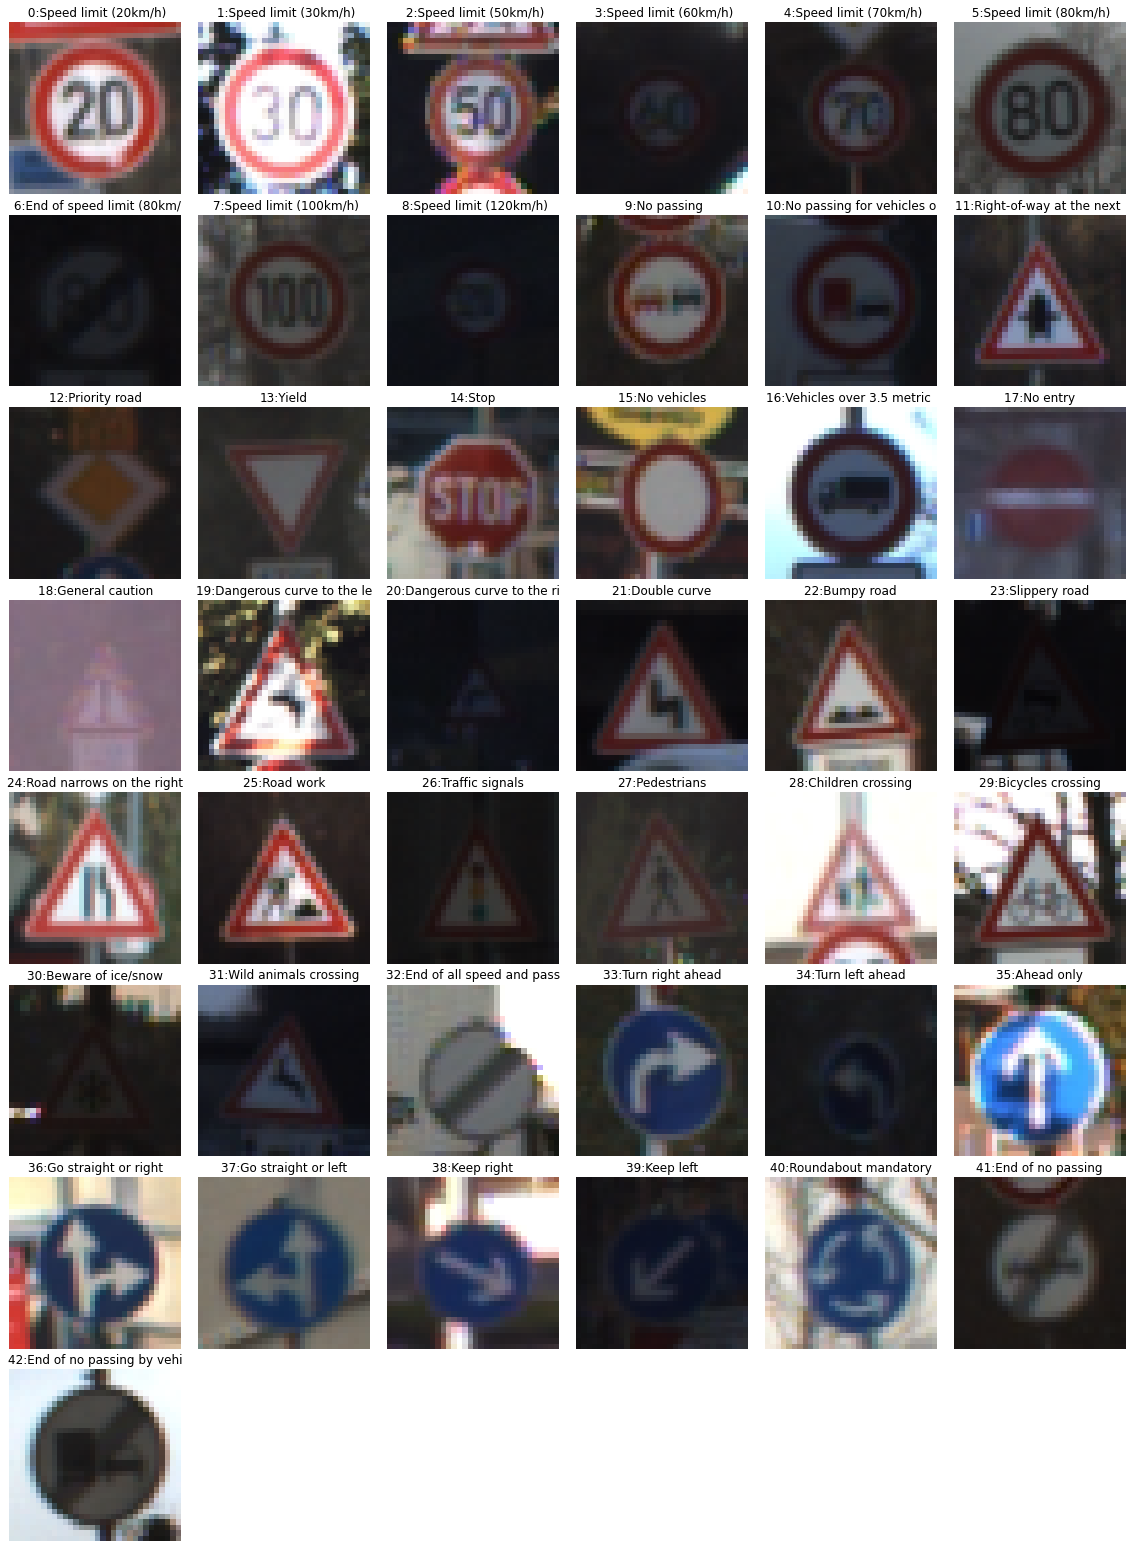

In [7]:
# Visualizations will be shown in the notebook.

# Pick the first image from the training set for each sign and display its name
plot_lbl_imgs(X_train,y_train, gray=False)

#### Analyze arrangement of training data

In [8]:
for lbl_id, lbl_desc in labels_sign_name.items():
    n_lbl_imgs = len(np.where(y_train == lbl_id)[0])
    print("{0:5} - {1:2}:{2:50}".format(n_lbl_imgs, lbl_id, lbl_desc), end='')
    if(lbl_id%2 == 1):
        print('')

  180 -  0:Speed limit (20km/h)                               1980 -  1:Speed limit (30km/h)                              
 2010 -  2:Speed limit (50km/h)                               1260 -  3:Speed limit (60km/h)                              
 1770 -  4:Speed limit (70km/h)                               1650 -  5:Speed limit (80km/h)                              
  360 -  6:End of speed limit (80km/h)                        1290 -  7:Speed limit (100km/h)                             
 1260 -  8:Speed limit (120km/h)                              1320 -  9:No passing                                        
 1800 - 10:No passing for vehicles over 3.5 metric tons       1170 - 11:Right-of-way at the next intersection             
 1890 - 12:Priority road                                      1920 - 13:Yield                                             
  690 - 14:Stop                                                540 - 15:No vehicles                                       
  360 - 16:Vehic

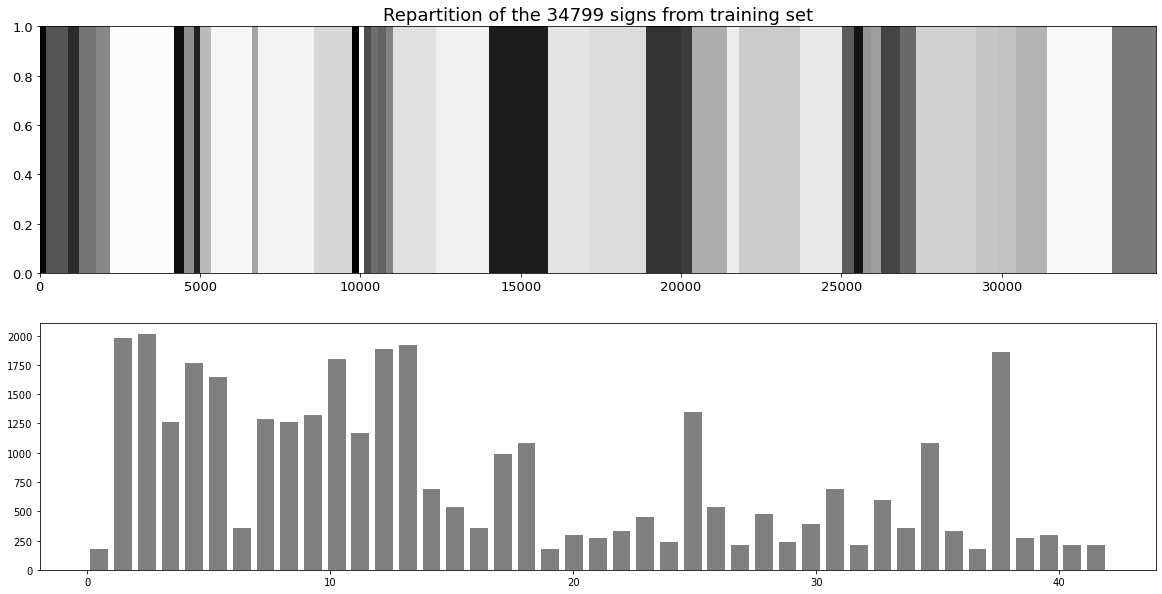

In [9]:
fig, (ax11, ax21) = plt.subplots(2, 1, figsize=(20, 10))
ax11.pcolor(np.asarray([y_train]), cmap = 'Greys')
ax11.set_title("Repartition of the {} signs from training set".format(len(y_train)), fontsize=18)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax21.hist(np.asarray(y_train), bins=n_classes, rwidth=0.75, color="Grey")

plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/168c60f1-cc92-450a-a91b-e427c326e6a7/modules/95d62426-4da9-49a6-9195-603e0f81d3f1/lessons/fe16d91d-bc00-455b-bc7b-a61b5e55d473/concepts/58b70b90-05a6-40c5-8b7a-e97079cb3848) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [10]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

#### Resize data
No need for the pickled image, the pickled list is already 32*32.<br/>
Assuming all processed images are square (if not, distortion will occur while resizing)

In [11]:
def resize_img(img, w=32, h=32, interpolation=cv2.INTER_AREA):
    # INTER_AREA is the closest to PIL ANTIALIAS
    dst = cv2.resize(img, (w, h),  interpolation=interpolation)
    #img.thumbnail((w, w), Image.ANTIALIAS)
    return dst

#### Augment dataset
Augmentation methods used:
 * Random horizontal / vertical translate
 * Random rotate (almost same result as perspective warp would do)
 * Random scale (zoom/unzoom)
 * Random perspective warp (as used in lane finding)
 * Random brightness change

In [12]:
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html#translation
def rand_translate(img, px=2):
    # _ for unrelevant color axis shape
    rows,cols,_ = img.shape
    
    # Allow translation from -2 to 2 pixels for x and y (2) directions    
    d_x, d_y = np.random.randint(-px,px,2)
    
    # Translate from d_x / d_y pixels and leave black pixels behind
    M = np.float32([[1,0,d_x],[0,1,d_y]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    
    return dst

# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html#rotation
def rand_rotate(img, theta=5):
    # _ for unrelevant color axis shape
    rows,cols,_ = img.shape
    
    # Allow rotation from -theta to +theta degrees 
    d_theta = np.random.randint(-theta,theta)
    
    # Rotate from d_theta degrees and leave black pixels behind    
    M = cv2.getRotationMatrix2D((cols/2,rows/2),d_theta,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    
    return dst

def rand_scale(img, px=2):
    # _ for unrelevant color axis shape
    rows,cols,_ = img.shape
    
    # Allow scaling to be between -px to +px pixels from the corners
    d_px = np.random.randint(-px,px)
    
    # Source edges location
    src_pts = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])
    # Destination edges location    
    dst_pts = np.float32([[d_px,d_px],[rows-d_px,d_px],[d_px,cols-d_px],[rows-d_px,cols-d_px]])
    
    # Scale zoom in or out
    M = cv2.getPerspectiveTransform(dst_pts, src_pts)    
    dst = cv2.warpPerspective(img,M,(cols,rows))
    
    return dst

# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html#perspective-transformation
def rand_perspective(img, px=2):
    # _ for unrelevant color axis shape
    rows,cols,_ = img.shape
    
    # Allow perspective destination points to be between -px to +px pixels from the corners
    d_tl_x, d_tl_y, d_bl_x, d_bl_y, d_tr_x, d_tr_y, d_br_x, d_br_y = np.random.randint(-px,px,8)
    
    # Source edges location
    src_pts = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])
    # Destination edges location    
    dst_pts = np.float32([[d_tl_x,d_tl_y],[rows-d_bl_x,d_bl_y],[d_tr_x,cols-d_tr_y],[rows-d_br_x,cols-d_br_y]])
    
    # Warp
    M = cv2.getPerspectiveTransform(dst_pts, src_pts)
    dst = cv2.warpPerspective(img,M,(cols,rows))
    
    return dst

def rand_hsv_channel(img, channel, shift=64):
    rows,cols,_ = img.shape
        
    # Transform image to HSV to easily manipulate brightness/saturation
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # Allow channel shift to be between -shift to +shift V
    d_shift = np.random.randint(-shift,shift)
    hsv[:,:,channel] = cv2.add(hsv[:,:,channel],d_shift)    
    dst = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return dst

def rand_hsv_v(img, shift=64):
    return rand_hsv_channel(img, 2, shift=64)

def rand_hsv_s(img, shift=64):
    return rand_hsv_channel(img, 1, shift=64)

def rand_transform(img):
    # Translate, Change perspective (can result in zoom in or out or even rotation), Brightness adjust
    return rand_translate(rand_perspective(rand_hsv_v(img)))

In [13]:
def augment_lbl(imgs, lbls, min_count=750):
    # For each label
    for lbl in np.unique(lbls):
        # Augment any data up to min_count if necessary
        lbl_list = np.where(lbls == lbl)[0]
        lbl_count = len(lbl_list)
        lbl_augment = min_count - lbl_count
        if lbl_augment > 0:
            print("Label {0:2}: {1:5} images - {2} augmentations required".format(lbl, lbl_count, lbl_augment))
            # Add as many augmented images as necessary
            for i in range(lbl_augment):
                # Pick images one after the other, and loop if necessary
                rand_img = imgs[lbl_list[i % lbl_count]]
                rand_img = rand_transform(rand_img)
                imgs = np.concatenate((imgs, [rand_img]))
                lbls = np.concatenate((lbls, [lbl]))
        else:
            print("Label {0:2}: {1:5} images - No augmentation required".format(lbl, lbl_count))
    
    return imgs, lbls

In [14]:
X_train, y_train = augment_lbl(X_train, y_train)

Label  0:   180 images - 570 augmentations required
Label  1:  1980 images - No augmentation required
Label  2:  2010 images - No augmentation required
Label  3:  1260 images - No augmentation required
Label  4:  1770 images - No augmentation required
Label  5:  1650 images - No augmentation required
Label  6:   360 images - 390 augmentations required
Label  7:  1290 images - No augmentation required
Label  8:  1260 images - No augmentation required
Label  9:  1320 images - No augmentation required
Label 10:  1800 images - No augmentation required
Label 11:  1170 images - No augmentation required
Label 12:  1890 images - No augmentation required
Label 13:  1920 images - No augmentation required
Label 14:   690 images - 60 augmentations required
Label 15:   540 images - 210 augmentations required
Label 16:   360 images - 390 augmentations required
Label 17:   990 images - No augmentation required
Label 18:  1080 images - No augmentation required
Label 19:   180 images - 570 augmentation

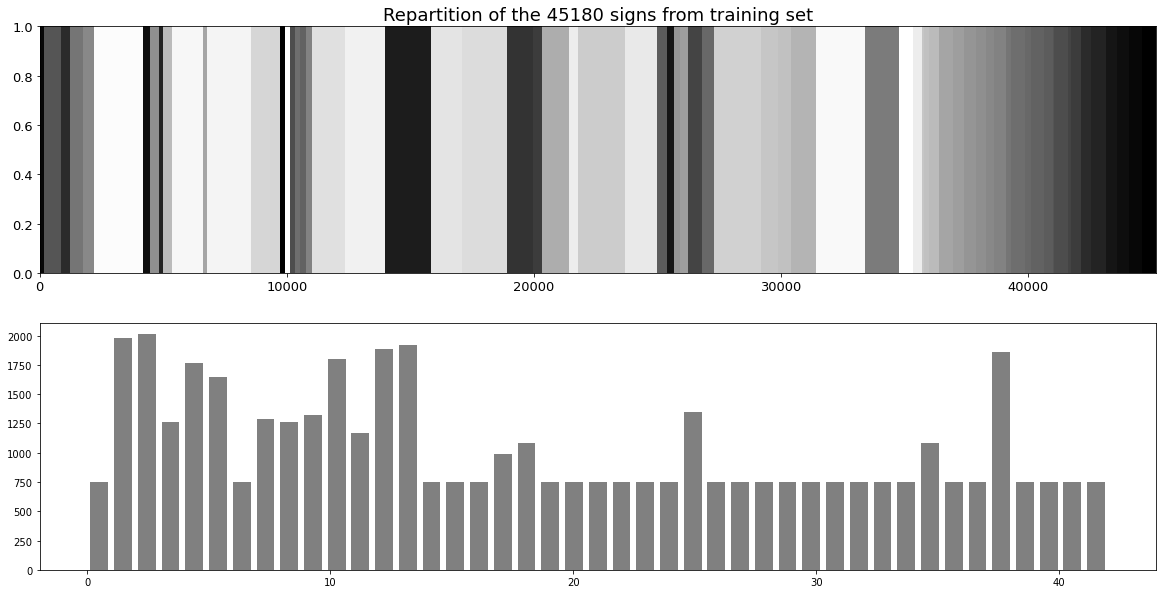

In [15]:
fig, (ax11, ax21) = plt.subplots(2, 1, figsize=(20, 10))
ax11.pcolor(np.asarray([y_train]), cmap = 'Greys')
ax11.set_title("Repartition of the {} signs from training set".format(len(y_train)), fontsize=18)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax21.hist(np.asarray(y_train), bins=n_classes, rwidth=0.75, color="Grey")

plt.show()

#### Grayscale

In [ ]:
# Grayscale

# https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python/45338831
def rgb_2_gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

# Convert training and test set to grayscale
X_train_gray = rgb_2_gray(X_train)

In [ ]:
plot_lbl_imgs(X_train_gray,y_train, gray=True)

#### Shuffle data
Shuffle (after grayscale to manipulate less data) the set so that no drift occurs after many successions of the same sign during the learning

In [ ]:
def UnisonShuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X_train_shfld, y_train_shfld = UnisonShuffle(X_train_gray, y_train)
# TODO Figure out how to pass the shuffled labels to plt
#train_ds = tf.data.Dataset.from_tensor_slices((X_train_pipeline, y_train_pipeline)).shuffle(5000)


In [ ]:
fig, ax11 = plt.subplots(1, 1, figsize=(20, 5))
ax11.pcolor(np.asarray([y_train_shfld]), cmap = 'Greys')
ax11.set_title("Shuffled training set repartition".format(len(y_train_shfld)), fontsize=18)
ax11.tick_params(axis='both', which='major', labelsize=13)

plt.show()

#### Normalize datasets to [ -1, 1 ]
Normalize data to obtain a mean close to 0 and try to speed up learning and reach faster convergence

In [ ]:
def NormalizeGray(imgs):
    # Subtract half the max (256) value to center around 0 then divide by the same value to obtain a [-1;1] range
    return (imgs - 128)/128     

In [ ]:
print("Non normalized:")
print("- Training set:\t{:06.3f}".format(np.mean(X_train_shfld)))

X_train_nrmlzd = NormalizeGray(X_train_shfld)

print("Normalized:")
print("- Training set:\t{:06.3f}".format(np.mean(X_train_nrmlzd)))


### Model Architecture
The model architecture is based on the LeNet architecture [class](https://classroom.udacity.com/nanodegrees/nd013/parts/168c60f1-cc92-450a-a91b-e427c326e6a7/modules/95d62426-4da9-49a6-9195-603e0f81d3f1/lessons/fe16d91d-bc00-455b-bc7b-a61b5e55d473/concepts/58b70b90-05a6-40c5-8b7a-e97079cb3848) as suggested:

LAYER | DESCRIPTION | ENHANCE?
--- | --- | --- |
a | b | c |
a | b | c |
a | b | c |





### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [ ]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

#### Setup TensorFlow

In [ ]:
# Dataset parameters.
num_classes = n_classes # 43 signs
num_features = X_train[0].shape[0] * X_train[0].shape[1] # 32*32

# Training parameters.
EPOCHS = 60
learning_rate = 0.0005
BATCH_SIZE = 128

In [ ]:
from tensorflow.contrib.layers import flatten

def traffic_sign_classifier(x):
    mu = 0
    sigma = 0.1
    # Got depth idea from https://github.com/agarwa65/Traffic_Sign_Classifier/blob/master/Traffic_Sign_Classifier.ipynb
    depth = 1 #for grayscale images and 3 for color images
    #depth = 3
    
    # Layer 1: Convolution 28x28x6 (32-5+1)
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5,5,1,6),mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1,1,1,1], padding='VALID') + conv1_b
    # Activation
    conv1 = tf.nn.relu(conv1)
    # Pooling 14x14x6 (28/2)
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # Layer 2: Convolution 10x10x6 (14-5+1)
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5,5,6,16),mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1,1,1,1], padding='VALID') + conv2_b
    # Activation
    conv2 = tf.nn.relu(conv2)
    # Pooling 5x5x6 (10/2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

    # Flatten 400 (5*5*16)
    fc0 = flatten(conv2)
    
    # Layer 3 
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400,120),mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    # Activation
    fc1 = tf.nn.relu(fc1)
    
    # Layer 4
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120,84),mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    # Activation
    fc2 = tf.nn.relu(fc2)
    
    # Layer 4 Fully connected to classes
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84,n_classes),mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [ ]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None)) # Sparse
one_hot_y = tf.one_hot(y, num_classes)


In [ ]:
logits = traffic_sign_classifier(x)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

In [ ]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

def add_feature_axis(imgs):
    try:
        imgs.shape[3]
    except:
        imgs = imgs[:, :, :, np.newaxis]
        pass
    return imgs

In [ ]:
# Preprocess data / Rename
X_train_ml = add_feature_axis(X_train_nrmlzd)
y_train_ml = y_train_shfld
# Preprocess validation data
X_valid_gray = rgb_2_gray(X_valid)
X_valid_nrmlzd = NormalizeGray(X_valid_gray)
X_valid_ml = add_feature_axis(X_valid_nrmlzd)
y_valid_ml = y_valid

In [ ]:
# Ask before retraining
train = True
if isfile('./lenet.meta'):
    inp = input("Retrain model? (Y for Yes or anything else for No): ")    
    if inp != "Y" and inp != "Yes" and inp != "y" and inp != "yes":
        train = False

if train:
    print("Model WILL BE be retrained")
else:
    print("Model will NOT be retrained")

In [ ]:
if train:  
    with tf.Session() as sess:
        validation_accuracy = None
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train_ml)

        print("Training: epochs:{}, learning rate:{}, batch size:{}...".format(EPOCHS, learning_rate, BATCH_SIZE))
        for i in range(EPOCHS):
            print("EPOCH {} ...".format(i+1))
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train_ml[offset:end], y_train_ml[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

            training_accuracy  = evaluate(X_train_ml, y_train_ml)
            validation_accuracy = evaluate(X_valid_ml, y_valid_ml)
            print("Training Accuracy = {:.3f}".format(training_accuracy ))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))

        try:
            saver
        except NameError:
            saver = tf.train.Saver()
        saver.save(sess, 'lenet')
        print("Model saved")
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))

#### Trials & Results
##### 1. Lenet from course
Met issues with placeholders and data set dimensions along with TensorFlow/Python version (abandonned trying to use TF 2.0)
No parameters tuning was performed, used course values
Normal LeNet implementation yielded around 0.05% accuracy with 5 epochs, 128 batch size, 0.1 learning rate
##### 2. Parameters optimization
Set epochs to 10 and batch size to 256 to help reach better accuracy without degrading speed too much
 * No average accuracy change

Tried descending learning rates to find sweet spot: 
 * 0.1 -> 0.054 (Does not converge)
 * 0.01 -> 0.87;0.93]
 * 0.001 -> [0.81;0.92]
 * 0.0001 -> [0.59;0.87]
 * 0.00001 -> 0.09 (Too slow to converge)
 
Tried to raise number of epochs to 60 for between 0.001 and 0.0001 to see if better results can be achieved:
 * 0.0005 -> [0.92;0.93] : Keeping this value for now
 
Issues with test and real world images yielding 0%

##### 4. Future
 * Augment data
 * Try color 

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
#reading in an image


X_new = []

new_imgs_dir = "./data/new_images"
    
X_new = []
y_new = [17, 9, 25, 23, 14]

new_imgs = [join(new_imgs_dir, f) for f in listdir(new_imgs_dir) if isfile(join(new_imgs_dir, f))]
for new_img in new_imgs:    
    #X_new.append(Image.open(new_img))
    X_new.append(cv2.cvtColor(cv2.imread(new_img), cv2.COLOR_BGR2RGB))
    
plot_imgs(X_new,y_new)

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

#### Resize

In [ ]:
for i in range(len(X_new)):
    X_new[i] = resize_img(X_new[i], interpolation=cv2.INTER_AREA)
    X_new[i] = np.array(X_new[i])

X_new = np.array(X_new)

plot_imgs(X_new,y_new)

In [ ]:
for i in range(len(X_new)):
    X_new[i] = rand_transform(X_new[i])

X_new = np.array(X_new)

plot_imgs(X_new,y_new)

#### Grayscale

In [ ]:
X_new_gray = rgb_2_gray(X_new)
plot_imgs(X_new_gray,y_new, gray=True)

#### Normalize

In [ ]:
print("Non normalized:\t{:06.3f}".format(np.mean(X_new_gray)))
X_new_nrmlzd = NormalizeGray(X_new_gray)
print("Normalized:\t{:06.3f}".format(np.mean(X_new_nrmlzd)))

In [ ]:
X_new_ml = add_feature_axis(X_new_nrmlzd)
y_new_ml = y_new

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

In [ ]:
plot_imgs(X_new_ml,y_new_ml, gray=True)

In [ ]:
# Preprocess validation data
X_test_gray = rgb_2_gray(X_test)
X_test_nrmlzd = NormalizeGray(X_test_gray)
X_test_ml = add_feature_axis(X_test_nrmlzd)
y_test_ml = y_test

In [ ]:
with tf.Session() as sess:    
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")    
    new_accuracy = evaluate(X_new_ml, y_new_ml)
    #new_accuracy = evaluate(X_test_ml, y_test_ml)
    #ew_accuracy = evaluate(X_valid_ml, y_valid_ml)
    print("Test Set Accuracy = {:.3f}".format(new_accuracy))

In [ ]:
#Reminder: logits = traffic_sign_classifier(x)
prediction=tf.argmax(logits,1)

def predict(X_data):
    sess = tf.get_default_session()    
    predictions = sess.run(prediction, feed_dict={x: X_data})
    return predictions

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    predictions = predict(X_new_ml)
    
    plot_imgs(X_new_ml,predictions, gray=True)    

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

In [ ]:
def plotTop_k(test_images, top_k):
    probabilities = top_k.values
    indices = top_k.indices
    assert (len(test_images) == len(indices))
    
    plot_imgs = []
    plot_headers = []
    plot_lbls = []
    
    for i in range(len(test_images)):
        # Append new image with empty title
        plot_imgs.append(test_images[i])
        plot_headers.append("")
        
        # Append for each top K       
        for j in range(len(indices[i])):
            lbl = indices[i][j]
            # Find a random image in the training set
            plot_imgs.append(rand_lbl_img(X_train, y_train, lbl))           
            # Add probability and label as header
            probability = probabilities[i][j] * 100
            header = "{:.2f}% : {:>2}:{:.25}".format(probability, lbl, labels_sign_name[lbl])            
            plot_headers.append(header)
            
    plot_imgs(plot_imgs,header=plot_headers, imgs_limit=100)

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
softmax_logits = tf.nn.softmax(logits)
top_k=tf.nn.top_k(softmax_logits,5)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    top_k = sess.run(top_k, feed_dict={x: X_new_ml})
    
    plotTop_k(X_new, top_k)
    #visualizeTop_k2(X_test, X_train, top_k)


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")